# PRELIMINARY

## CONNECT DRIVE

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## IMPORT LIBRARIES

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Suppress TensorFlow logging messages
tf.get_logger().setLevel(logging.ERROR)

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import pandas as pd

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## LOAD DATA

In [ ]:
data = np.load('clean_training_set.npz')
X = data['images']
y = data['labels']

In [ ]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (11959, 96, 96, 3)
y shape: (11959, 1)


## PLOT DATA

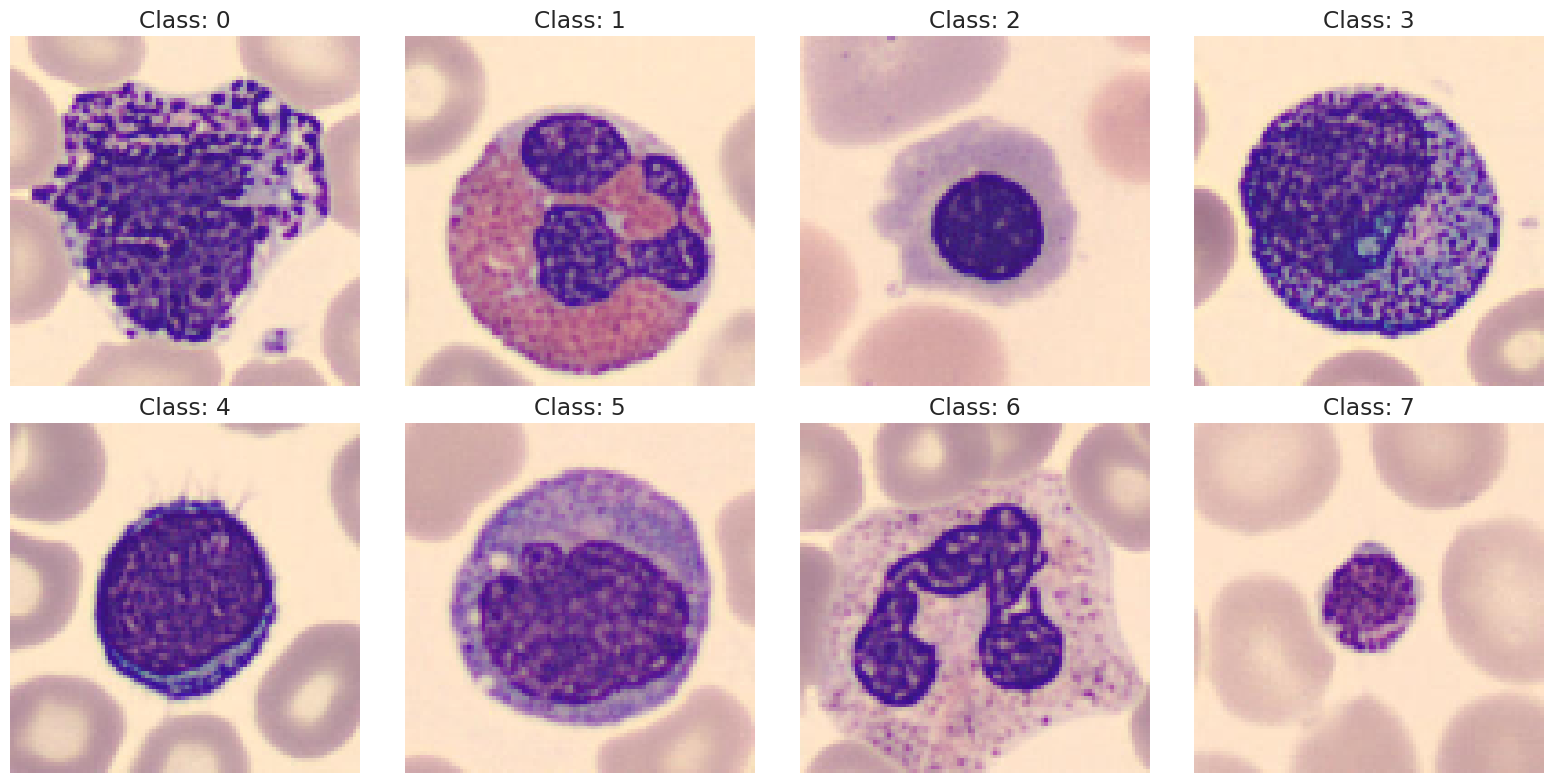

In [ ]:
def plot_random_examples_per_class(X, y):
  """Plots one random example per class from the given data.

  Args:
    X: The input data (images).
    y: The corresponding labels.
  """

  classes = np.unique(y)
  num_classes = len(classes)
  examples_per_class = {}

  for class_label in classes:
    indices = np.where(y == class_label)[0]
    random_index = random.choice(indices)
    examples_per_class[class_label] = X[random_index]

  plt.figure(figsize=(16, 8))
  gs = gridspec.GridSpec(2, 4)

  for i, (class_label, example) in enumerate(examples_per_class.items()):
    ax = plt.subplot(gs[i // 4, i % 4])
    ax.imshow(example)
    ax.set_title(f"Class: {class_label}")
    ax.axis('off')

  plt.tight_layout()
  plt.show()

plot_random_examples_per_class(X, y)

## ROBE NUOVE

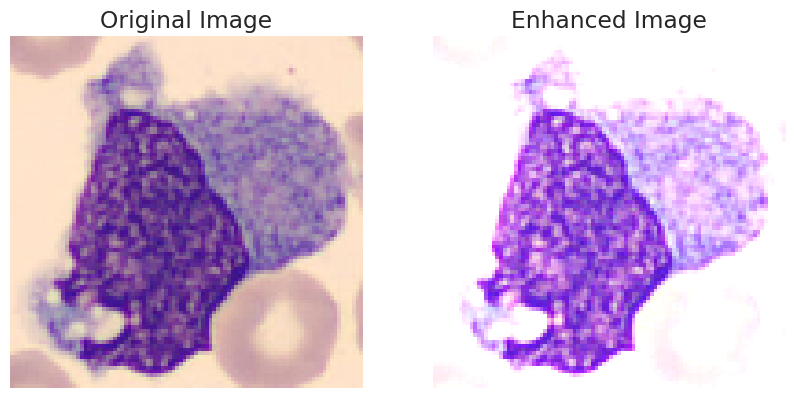

In [ ]:
def enhance_contrast_saturation(image, alpha=1.5, beta=0):
  """Enhances the contrast and saturation of an image.

  Args:
    image: The input image as a NumPy array.
    alpha: The contrast control (1.0-3.0).
    beta: The brightness control (0-100).

  Returns:
    The enhanced image.
  """
  enhanced_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
  return enhanced_image

# Select a random image
random_index = random.randint(0, len(X) - 1)
image = X[random_index]

# Enhance the image
enhanced_image = enhance_contrast_saturation(image)

# Plot the original and enhanced images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title("Enhanced Image")
plt.axis('off')

plt.show()

In [ ]:
# prompt: Trasforma l'intero dataset in versione Enhanced, salvandolo in X. Il vecchio inseriscilo in X_old

X_old = X.copy()  # Create a copy of the original dataset
X = np.array([enhance_contrast_saturation(image) for image in X])

# MODEL

## PREPARE DATA

### ONE HOT

In [ ]:

from tensorflow.keras.utils import to_categorical

# Assuming 'y' contains your labels as integers
y_one_hot = to_categorical(y)

print("y_one_hot shape:", y_one_hot.shape)

y_one_hot shape: (11959, 8)


### SPLIT DATASET

In [ ]:

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_one_hot, test_size=0.3, random_state=seed, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8371, 96, 96, 3)
y_train shape: (8371, 8)
X_val shape: (1794, 96, 96, 3)
y_val shape: (1794, 8)
X_test shape: (1794, 96, 96, 3)
y_test shape: (1794, 8)


### WEIGHTS

In [ ]:

from collections import Counter

def compute_class_weights(y):
  """Computes class weights based on the inverse of the class frequencies.

  Args:
    y: The labels for the dataset.

  Returns:
    A dictionary mapping class labels to their corresponding weights.
  """
  counter = Counter(y)
  num_classes = len(counter)
  class_weights = {}
  total_samples = len(y)

  for class_label in range(num_classes):
    class_weight = total_samples / (num_classes * counter[class_label])
    class_weights[class_label] = class_weight
  return class_weights

# Example usage:
# Assuming y_train contains your training labels as integers
class_counts = Counter(np.argmax(y_train, axis=1))
print("Class counts:", class_counts)

# Compute class weights
class_weights = compute_class_weights(np.argmax(y_train, axis=1))

print("Class weights:", class_weights)

Class counts: Counter({6: 1631, 1: 1527, 3: 1418, 7: 1150, 2: 760, 5: 695, 0: 596, 4: 594})
Class weights: {0: 1.7556627516778522, 1: 0.6852488539620171, 2: 1.3768092105263159, 3: 0.7379231311706629, 4: 1.7615740740740742, 5: 1.5055755395683452, 6: 0.6415542611894544, 7: 0.9098913043478261}


### DEFINE IN/OUT SHAPE

In [ ]:

input_shape = X_train.shape[1:]  # Shape of the input images (excluding the batch dimension)
output_shape = y_train.shape[1]  # Number of classes in the dataset

print("Input shape:", input_shape)
print("Number of classes:", output_shape)

Input shape: (96, 96, 3)
Number of classes: 8


## DEFINE GENERATOR

In [ ]:
augmentation_model = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape),
    #tfkl.Rescaling(1./255),  # Rescale pixel values to [0, 1]
    tfkl.RandomRotation(factor=10/360, fill_mode='nearest'),  # Random rotation (10 degrees)
    tfkl.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='nearest'),  # Random translation
    tfkl.RandomFlip("horizontal"),  # Random horizontal flip
    tfkl.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest'),  # Random zoom
    tfkl.Resizing(120, 120),  # Resize to 96x96
    tfkl.RandomCrop(96, 96),  # Random crop to 96x96
    tfkl.GaussianNoise(0.1)  # Add Gaussian noise
])

## DEFINE MODEL

In [ ]:

base_model = tfk.applications.ConvNeXtTiny(
    weights='imagenet', include_top=False, input_shape=input_shape
)

# Freeze the base model layers
for layer in base_model.layers:
  layer.trainable = False

# Create the model
model = tfk.Sequential([
    augmentation_model,  # Apply data augmentation
    base_model,
    tfkl.GlobalAveragePooling2D(),
    tfkl.Dense(256, activation='relu'),
    tfkl.Dropout(0.5),
    tfkl.Dense(output_shape, activation='softmax', kernel_regularizer=tfk.regularizers.l2(0.01))
])

# Compile the model
model.compile(
    optimizer=tfk.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with the base model frozen
epochs = 50
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('enhanced_check_v2.weights.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1, save_weights_only=True)

history = model.fit(
    tfk.applications.convnext.preprocess_input(X_train), y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint]
)

# Unfreeze the last 15 layers of the base model
for layer in base_model.layers[-15:]:
  layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tfk.optimizers.SGD(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training the model with the unfrozen layers
epochs = 50
history_fine_tune = model.fit(
    tfk.applications.convnext.preprocess_input(X_train), y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, checkpoint]
)

# Save the final model
model.save('ConvNeXtTiny_enhanced_model_v3.keras')

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4497 - loss: 1.7436
Epoch 1: val_accuracy improved from -inf to 0.60814, saving model to enhanced_check_v2.weights.h5
262/262 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - accuracy: 0.4502 - loss: 1.7422 - val_accuracy: 0.6081 - val_loss: 1.2844
Epoch 2/50
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7338 - loss: 0.9826
Epoch 2: val_accuracy improved from 0.60814 to 0.64047, saving model to enhanced_check_v2.weights.h5
262/262 ━━━━━━━━━━━━━━━━━━━━ 26s 98ms/step - accuracy: 0.7339 - loss: 0.9821 - val_accuracy: 0.6405 - val_loss: 1.1431
Epoch 3/50
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7784 - loss: 0.8172
Epoch 3: val_accuracy improved from 0.64047 to 0.65942, saving model to enhanced_check_v2.weights.h5
262/262 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.7784 - loss: 0.8171 - val_accuracy: 0.6594 - val_loss: 1.0640
Epoch 4/50
261/262 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7950 - loss: 0

# TESTING

Best Model Summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_tiny (Functional)           │ (None, 3, 3, 768)           │      27,820,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 768)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,019,050 (106.88 MB)

 Trainable params: 9,726,728 (37.10 MB)

 Non-trainable params: 18,292,320 (69.78 MB)

 Optimizer params: 2 (12.00 B)

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.8285 - loss: 0.5718
Test Loss: 0.5622328519821167
Test Accuracy: 0.8260869383811951
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step
F1 Score: 0.6868665708459682
Precision: 0.7352365444769359
Recall: 0.6928651059085842


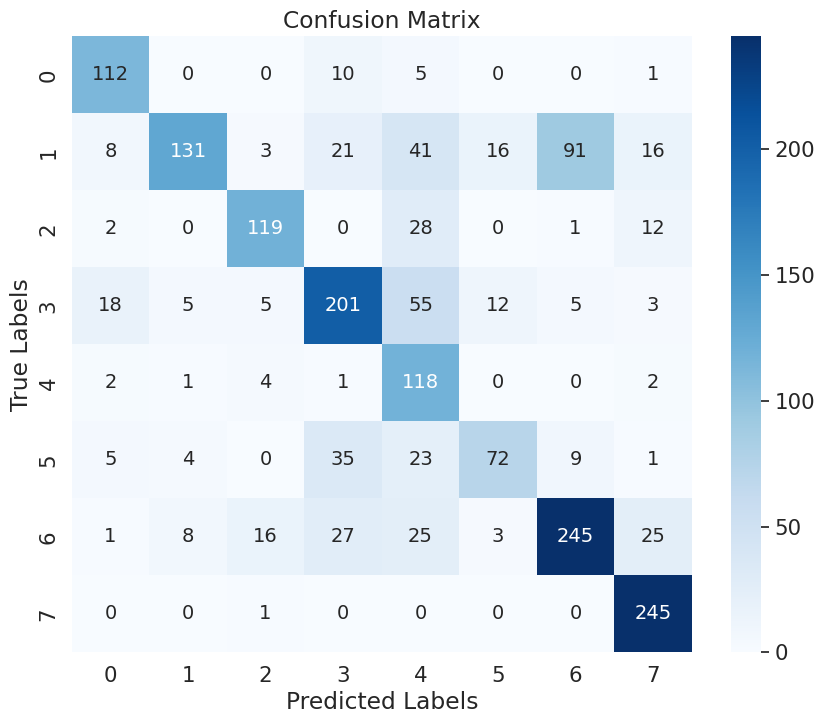

In [ ]:

# Load the best model
best_model = tfk.models.load_model('ConvNeXtTiny_enhanced_model_v3.keras')

print("Best Model Summary:")
best_model.summary();

# Evaluate the model on the test set
loss, accuracy = best_model.evaluate(tfk.applications.convnext.preprocess_input(X_test), y_test, verbose=1)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Generate predictions on the test set
y_pred = best_model.predict(tfk.applications.vgg19.preprocess_input(X_test))

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)


# Calculate other evaluation metrics
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

# Compute and display the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# FILE EXPORT

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('enhanced_model_v2.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py modelv5_fold3.keras

from google.colab import files
files.download(filename)